<a href="https://colab.research.google.com/github/Data-Science-and-Data-Analytics-Courses/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/blob/master/Week%2001%20Prediction%20Problems/NN_MNIST/Nearest_neighbor_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nearest neighbor for handwritten digit recognition

In this notebook we will build a classifier that takes an image of a handwritten digit and outputs a label 0-9. We will look at a particularly simple strategy for this problem known as the **nearest neighbor classifier**.

To run this notebook you should have the following Python packages installed:
* `numpy`
* `matplotlib`
* `sklearn`

# Clone GitHub remote repository to Google Colaboratory (run the following code cell one time only)

In [1]:
import os

repo_url = "https://github.com/Data-Science-and-Data-Analytics-Courses/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit".strip("/")
repo_to_notebook_dir = "Week 01 Prediction Problems/NN_MNIST"

# Clone remote repository to local repository
repo_name = os.path.basename(repo_url)
!git clone $repo_url
%cd "$repo_name"

# Change working directory to local notebook directory
%cd "$repo_to_notebook_dir"

Cloning into 'UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 81 (delta 26), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (81/81), done.
/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit
/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/Week 01 Prediction Problems/NN_MNIST


## 1. The MNIST dataset

`MNIST` is a classic dataset in machine learning, consisting of 28x28 gray-scale images handwritten digits. The original training set contains 60,000 examples and the test set contains 10,000 examples. In this notebook we will be working with a subset of this data: a training set of 7,500 examples and a test set of 1,000 examples.

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time

## Load the training set
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

## Load the testing set
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

In [3]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (7500, 784)
Number of training labels:  7500
Testing dataset dimensions:  (1000, 784)
Number of testing labels:  1000


In [5]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 750, 1: 750, 2: 750, 3: 750, 4: 750, 5: 750, 6: 750, 7: 750, 8: 750, 9: 750}
Test set distribution:
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


## 2. Visualizing the data
Each data point is stored as 784-dimensional vector. To visualize a data point, we first reshape it to a 28x28 image.

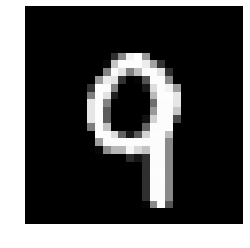

Label 9


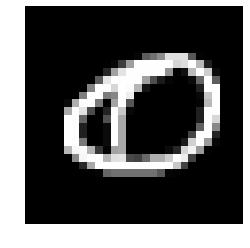

Label 0


In [6]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

## 3. Squared Euclidean distance

To compute nearest neighbors in our data set, we need to first be able to compute distances between data points. A natural distance function is _Euclidean distance_: for two vectors $x, y \in \mathbb{R}^d$, their Euclidean distance is defined as 
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$
Often we omit the square root, and simply compute _squared Euclidean distance_:
$$\|x - y\|^2 = \sum_{i=1}^d (x_i - y_i)^2.$$
For the purposes of nearest neighbor computations, the two are equivalent: for three vectors $x, y, z \in \mathbb{R}^d$, we have $\|x - y\| \leq \|x - z\|$ if and only if $\|x - y\|^2 \leq \|x - z\|^2$.

Now we just need to be able to compute squared Euclidean distance. The following function does so.

In [7]:
## Computes squared Euclidean distance between two vectors.
def squared_dist(x,y):
    return np.sum(np.square(x-y))

## Compute distance between a seven and a one in our training set.
print("Distance from 7 to 1: ", squared_dist(train_data[4,],train_data[5,]))

## Compute distance between a seven and a two in our training set.
print("Distance from 7 to 2: ", squared_dist(train_data[4,],train_data[1,]))

## Compute distance between two seven's in our training set.
print("Distance from 7 to 7: ", squared_dist(train_data[4,],train_data[7,]))

Distance from 7 to 1:  5357193.0
Distance from 7 to 2:  12451684.0
Distance from 7 to 7:  5223403.0


## 4. Computing nearest neighbors

Now that we have a distance function defined, we can now turn to nearest neighbor classification. 

In [0]:
## Takes a vector x and returns the index of its nearest neighbor in train_data
def find_NN(x):
    # Compute distances from x to every row in train_data
    distances = [squared_dist(x,train_data[i,]) for i in range(len(train_labels))]
    # Get the index of the smallest distance
    return np.argmin(distances)

## Takes a vector x and returns the class of its nearest neighbor in train_data
def NN_classifier(x):
    # Get the index of the the nearest neighbor
    index = find_NN(x)
    # Return its class
    return train_labels[index]

A success case:
NN classification:  0
True label:  0
The test image:


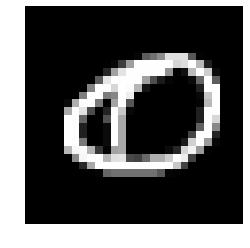

Label 0
The corresponding nearest neighbor image:


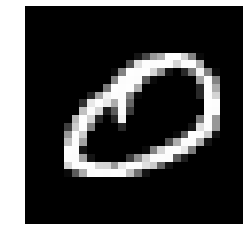

Label 0


In [9]:
## A success case:
print("A success case:")
print("NN classification: ", NN_classifier(test_data[0,]))
print("True label: ", test_labels[0])
print("The test image:")
vis_image(0, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[0,]), "train")

A failure case:
NN classification:  2
True label:  3
The test image:


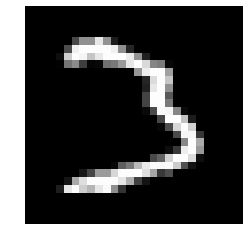

Label 3
The corresponding nearest neighbor image:


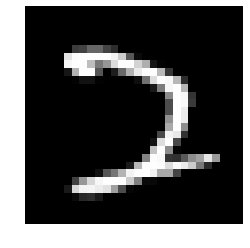

Label 2


In [10]:
## A failure case:
print("A failure case:")
print("NN classification: ", NN_classifier(test_data[39,]))
print("True label: ", test_labels[39])
print("The test image:")
vis_image(39, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[39,]), "train")

## 5. For you to try
The above two examples show the results of the NN classifier on test points number 0 and 39.

Now try test point number 100.
* What is the index of its nearest neighbor in the training set? _Record the answer: you will enter it as part of this week's assignment._
* Display both the test point and its nearest neighbor.
* What label is predicted? Is this the correct label?

NN classification:  4
True label:  4
The test image:


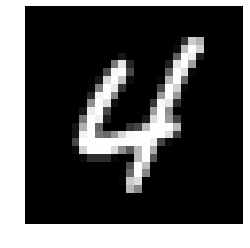

Label 4
The corresponding nearest neighbor image:


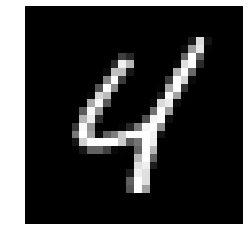

Label 4
correct label


In [12]:
# Test point number 100
print("NN classification: ", NN_classifier(test_data[100,]))
print("True label: ", test_labels[100])
print("The test image:")
vis_image(100, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[100,]), "train")
print("correct label")

## 6. Processing the full test set

Now let's apply our nearest neighbor classifier over the full data set. 

Note that to classify each test point, our code takes a full pass over each of the 7500 training examples. Thus we should not expect testing to be very fast. The following code takes about 100-150 seconds on 2.6 GHz Intel Core i5. 

In [13]:
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = [NN_classifier(test_data[i,]) for i in range(len(test_labels))]
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier: ", error)
print("Classification time (seconds): ", t_after - t_before)

Error of nearest neighbor classifier:  0.046
Classification time (seconds):  52.38509917259216


## 7. Faster nearest neighbor methods

Performing nearest neighbor classification in the way we have presented requires a full pass through the training set in order to classify a single point. If there are $N$ training points in $\mathbb{R}^d$, this takes $O(N d)$ time.

Fortunately, there are faster methods to perform nearest neighbor look up if we are willing to spend some time preprocessing the training set. `scikit-learn` has fast implementations of two useful nearest neighbor data structures: the _ball tree_ and the _k-d tree_. 

In [14]:
from sklearn.neighbors import BallTree

## Build nearest neighbor structure on training data
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
ball_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same
print("Ball tree produces same predictions as above? ", np.array_equal(test_predictions, ball_tree_predictions))

Time to build data structure (seconds):  0.5482151508331299
Time to classify test set (seconds):  8.062226057052612
Ball tree produces same predictions as above?  True


In [15]:
from sklearn.neighbors import KDTree

## Build nearest neighbor structure on training data
t_before = time.time()
kd_tree = KDTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(kd_tree.query(test_data, k=1, return_distance=False))
kd_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same
print("KD tree produces same predictions as above? ", np.array_equal(test_predictions, kd_tree_predictions))

Time to build data structure (seconds):  0.4972095489501953
Time to classify test set (seconds):  10.443819046020508
KD tree produces same predictions as above?  True
